In [7]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

'''
Exploratory data analysis for the tables {'cases', 'documents', 'points', 'services', 'topics'} dumped on oct 18th '21

Service - website, app, etc.
Point - a plain text highlight that summarizes as aspect of their policy. It is often a quote, but doesn't have to be, 
    e.g. "The terms for this service are easy to read". Each point is 1-1 with a Case.
Case - higher-level Service-agnostic patterns that Points exhibit. For example, "No third-party analytics or tracking platforms are used"
Topic - even higher-level patterns, that contain a handful of Cases. For example, "User Choice"
Document - crawled text from a Service

Foreign keys:
Service - user
Document - user, service
Topic - none
Case - topic
Point - user, service, case, document
'''

'\nExploratory data analysis for the tables {\'cases\', \'documents\', \'points\', \'services\', \'topics\'} dumped on oct 18th \'21\n\nService - website, app, etc.\nPoint - a plain text highlight that summarizes as aspect of their policy. It is often a quote, but doesn\'t have to be, \n    e.g. "The terms for this service are easy to read". Each point is 1-1 with a Case.\nCase - higher-level Service-agnostic patterns that Points exhibit. For example, "No third-party analytics or tracking platforms are used"\nTopic - even higher-level patterns, that contain a handful of Cases. For example, "User Choice"\nDocument - crawled text from a Service\n\nForeign keys:\nService - user\nDocument - user, service\nTopic - none\nCase - topic\nPoint - user, service, case, document\n'

In [8]:
VERSION = '211222'
cases = pickle.load(open(f'../data/cases_{VERSION}.pkl', 'rb'))
documents = pickle.load(open(f'../data/documents_{VERSION}.pkl', 'rb'))
points = pickle.load(open(f'../data/points_{VERSION}.pkl', 'rb'))
services = pickle.load(open(f'../data/services_{VERSION}.pkl', 'rb'))
topics = pickle.load(open(f'../data/topics_{VERSION}.pkl', 'rb'))

In [9]:
# Before we work with Services, it looks like there are deleted ones to remove
# We'll also want to remove related Documents and Points
print(services.status.value_counts())
deleted_service_ids = services[services.status == 'deleted'].id
services = services[~(services.status == 'deleted')].drop('status', axis=1)

documents = documents[~documents.service_id.isin(deleted_service_ids)]
points = points[~points.service_id.isin(deleted_service_ids)]

deleted    50
Name: status, dtype: int64


In [10]:
# inspect Services

services.info()
services.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5989 entries, 440 to 7107
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           5989 non-null   int64         
 1   name                         5989 non-null   object        
 2   url                          5989 non-null   object        
 3   created_at                   5989 non-null   datetime64[ns]
 4   updated_at                   5989 non-null   datetime64[ns]
 5   wikipedia                    5954 non-null   object        
 6   keywords                     302 non-null    object        
 7   related                      303 non-null    object        
 8   slug                         5989 non-null   object        
 9   is_comprehensively_reviewed  5989 non-null   bool          
 10  user_id                      1210 non-null   float64       
 11  rating                       5989 non-nul

,id,name,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id,rating
id,,,,,,,,,,,,
440,440,pebble,pebble.com,2018-05-08 12:19:44.833708,2021-03-25 03:19:30.208894,None,,,pebble,False,NaN,N/A
225,225,Spotify,"spotify.com,spotifyforvendors.com,spotifyjobs.com",2018-01-16 15:26:06.332058,2021-03-25 03:19:30.801812,https://en.wikipedia.org/wiki/Spotify,,soundcloud,spotify,True,NaN,E
183,183,CouchSurfing,"couchsurfing.org,couchsurfing.com",2018-01-16 15:26:05.544807,2021-03-25 03:19:31.618318,https://en.wikipedia.org/wiki/CouchSurfing,,,couchsurfing,True,NaN,E
219,219,Instagram,"instagram.com,help.instagram.com,about.instagr...",2018-01-16 15:26:06.211757,2021-03-25 03:19:31.833924,https://en.wikipedia.org/wiki/Instagram,,,instagram,True,NaN,E
186,186,Flickr,flickr.com,2018-01-16 15:26:05.601101,2021-03-25 03:19:32.888517,https://en.wikipedia.org/wiki/Flickr,"photos,pictures","twitpic,500px",flickr,True,NaN,E


Text(0.5, 1.0, 'Services added over time')

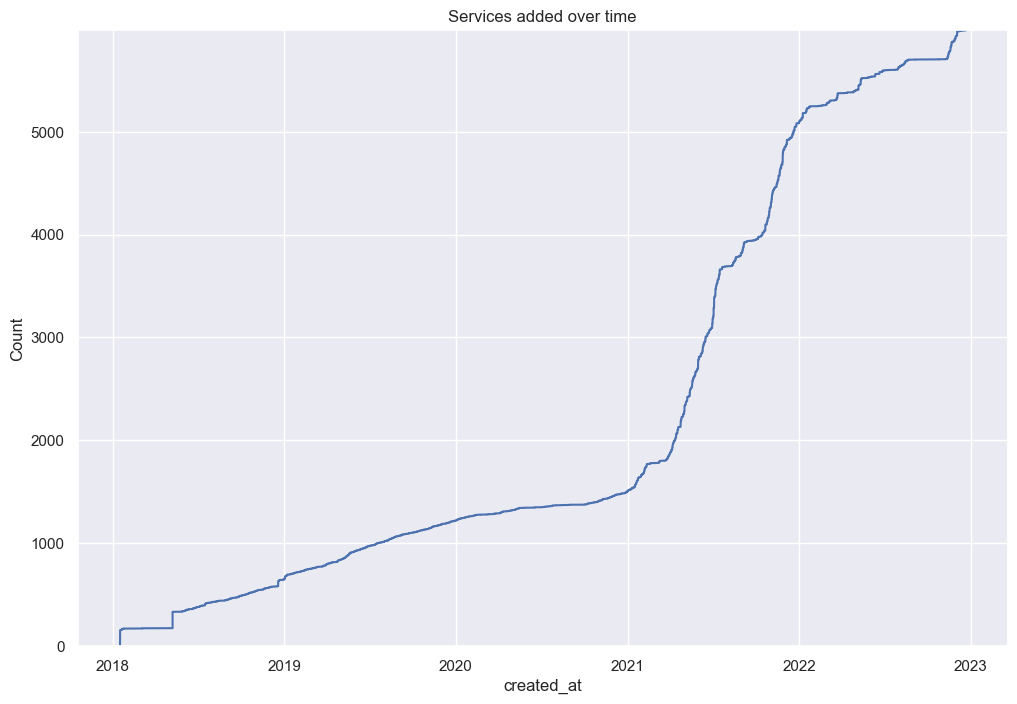

In [11]:
# How have the number of Services grown over time?
plt.figure(figsize=(12,8))
sns.ecdfplot(services, x='created_at', stat='count')
plt.title('Services added over time')

In [12]:
# How many have been comprehensively reviewed?
services.is_comprehensively_reviewed.value_counts()

False    5558
True      431
Name: is_comprehensively_reviewed, dtype: int64

In [13]:
services.rating

id
440     N/A
225       E
183       E
219       E
186       E
       ... 
596       A
7104    N/A
7105    N/A
7106    N/A
7107    N/A
Name: rating, Length: 5989, dtype: object

Text(0.5, 1.0, 'Service ratings')

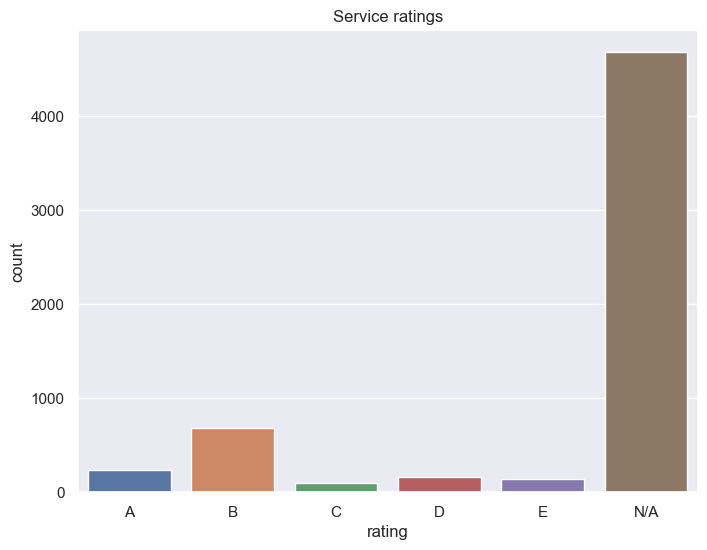

In [14]:
# What are they rated?
plt.figure(figsize=(8,6))
sns.countplot(x=services.rating, order=['A', 'B', 'C', 'D', 'E', 'N/A'])
plt.title('Service ratings')

In [15]:
# Like before, drop deleted Documents, and related Points
print(documents.status.value_counts())
deleted_document_ids = documents[documents.status == 'deleted'].id
documents = documents[~(documents.status == 'deleted')].drop('status', axis=1)
points = points[~points.document_id.isin(deleted_document_ids)]

deleted    21
Name: status, dtype: int64


In [16]:
# inspect Documents

documents.text = documents.text.replace('', np.nan)
documents.info()
documents.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12221 entries, 1149 to 13229
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              12221 non-null  int64         
 1   name            12221 non-null  object        
 2   url             12221 non-null  object        
 3   xpath           11941 non-null  object        
 4   text            9787 non-null   object        
 5   created_at      12221 non-null  datetime64[ns]
 6   updated_at      12221 non-null  datetime64[ns]
 7   service_id      12221 non-null  int64         
 8   reviewed        227 non-null    object        
 9   user_id         4798 non-null   float64       
 10  crawler_server  7950 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


,id,name,url,xpath,text,created_at,updated_at,service_id,reviewed,user_id,crawler_server
id,,,,,,,,,,,
1149,1149,social.privacytools.io Privacy Policy,https://social.privacytools.io/terms,/html/body/div/div[2]/div/div[1]/div,\nPrivacy <p>Please review our privacy stateme...,2019-04-06 02:39:01.465351,2020-12-14 19:29:56.243824,1472,None,NaN,None
2123,2123,Privacy Policy,https://mrichard333.com/Privacy-policy,,<ul>\n<li>Home</li>\n<li>Videos</li>\n<li>Con...,2019-11-11 16:04:52.941473,2020-12-15 00:51:52.643832,1728,None,3877.0,None
3719,3719,Privacy Policy,https://www.savvasrealize.com/privacy/corporat...,/html/body/main/div/section/div/div/div[1],Privacy Policy We recently updated our Privac...,2021-01-21 11:15:08.988939,2021-01-24 08:49:24.411559,2619,None,20760.0,None
7,7,Terms of Service,https://help.habbo.com/hc/en-us/articles/22164...,//div[@class='content-body article-body'],<p>\n<strong>Habbo.com - Terms of Service</st...,2018-07-17 10:11:40.691179,2020-12-11 14:20:59.218294,292,True,NaN,None
9,9,Terms of Service,https://500px.com/terms,//body,You need to enable JavaScript to run this app....,2018-07-17 10:11:40.759351,2021-03-30 21:11:14.017630,282,True,NaN,eu


In [17]:
# Most common Document names
documents.name.str.lower().str.strip().value_counts().head(25)

privacy policy                 4230
terms of service               1309
terms of use                   1002
terms and conditions            563
cookie policy                   426
terms                           291
terms & conditions              234
privacy                         141
privacy statement               133
privacy notice                  131
cookies policy                   81
refund policy                    62
terms and conditions of use      57
acceptable use policy            51
copyright policy                 47
dmca                             47
user agreement                   41
website terms of use             38
cookies                          36
end user license agreement       30
cookie notice                    30
code of conduct                  30
disclaimer                       29
return policy                    27
website privacy policy           26
Name: name, dtype: int64

In [18]:
# How many docs have no Points? Turns out, most of them
len(set(documents.id) - set(points.document_id))

9311

In [19]:
# In what languages are the docs?
from langdetect import detect
from langdetect import DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
DetectorFactory.seed = 0

def detect_lang(text):
    if text is None or pd.isnull(text) or text == '':
        return None
    try:
        return detect(text)
    except LangDetectException:
        return None

documents['lang'] = documents.apply(lambda doc: detect_lang(doc.text), axis=1)
documents.lang.value_counts()

en       9163
de        147
fr        121
it         44
nl         44
es         42
zh-cn      38
ru         27
ja         15
ca         14
ko         13
pt         12
ro         11
el          9
pl          9
no          7
tr          5
bg          4
sv          4
cs          4
da          4
et          4
id          4
ar          3
th          2
fi          2
cy          2
hu          2
he          2
hr          1
tl          1
Name: lang, dtype: int64

count      9787.000000
mean      21480.377133
std       29202.769830
min           1.000000
25%        6115.000000
50%       14719.000000
75%       28366.000000
max      830858.000000
Name: doc_len, dtype: float64


Text(0.5, 1.0, 'Document length (num characters)')

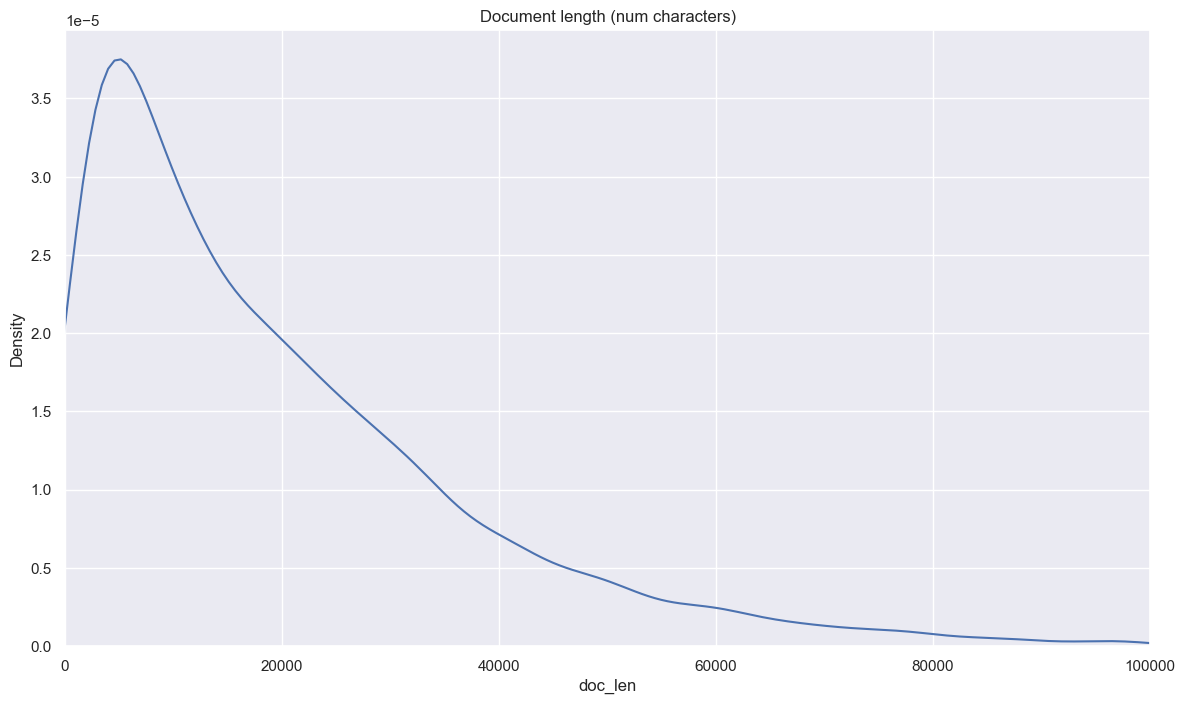

In [20]:
# Document lengths
documents['doc_len'] = documents.text.str.len()
print(documents.doc_len.describe())

# Graph the density (with outliers filtered so the x-axis is not stretched)
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim((0,100000))
sns.kdeplot(documents.doc_len[documents.doc_len < 100000], ax=ax)
plt.title('Document length (num characters)')

In [21]:
# Not sure what `reviewed` is based on, but most values are null/NaN
documents.reviewed.value_counts()

True     152
False     75
Name: reviewed, dtype: int64

In [22]:
documents.crawler_server.value_counts()

eu                                  3550
atlas                               1059
us                                  1005
nosypeeper                           943
avidreader                           674
nosypeeper.crawler.api.tosdr.org     222
arachne                              156
eu.crawler.api.tosdr.org             125
floppy                                86
floppy.crawler.api.tosdr.org          40
whale                                 24
james                                 14
arachne.crawler.api.tosdr.org         14
us-east.crawler.api.tosdr.org         13
dmitri                                12
whale.crawler.api.tosdr.org            5
avidreader.crawler.api.tosdr.org       4
atlas.crawler.api.tosdr.org            3
eu-central.crawler.api.tosdr.org       1
Name: crawler_server, dtype: int64

In [23]:
# Do a join to attach Service info to Documents
documents = pd.merge(documents, services, left_on='service_id', right_index=True, suffixes=['_doc', '_service'])

In [24]:
# Most Services have 1 or 2 documents, but some have a lot more
print(f"Documents per Service stats:\n{documents.service_id.value_counts().describe()}")
documents.groupby(['service_id', 'name_service']).size().sort_values(ascending=False).head(15)

Documents per Service stats:
count    5755.000000
mean        2.123545
std         1.352476
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        26.000000
Name: service_id, dtype: float64


service_id  name_service                       
190         Amazon                                 26
3850        bunq                                   23
2887        Albertsons Companies,(Subsidiaries)    23
3133        SailPoint                              22
4027        Sympla                                 21
1559        HERE Technologies                      21
1448        TikTok                                 17
3918        Optimum                                15
230         PayPal                                 14
2308        Rakuten                                14
312         Stack Overflow                         12
3938        Fred Meyer                             12
3917        Rise Broadband                         12
1566        Intercom                               11
186         Flickr                                 11
dtype: int64

In [25]:
# What are the Documents that cause these to be outliers? (replace service_id with one of the above. They are all legit AFAICT)
documents[documents.service_id == 2887][['name_doc', 'url_doc']]

,name_doc,url_doc
id,,
4468,Andronicos community market Privacy Policy,https://www.andronicos.com/privacy-policy
4469,The United Family Privacy Policy,https://www.theunitedfamily.com/privacy-policy/
4470,Albertsons Companies Privacy Policy,https://www.albertsonscompanies.com/about-us/o...
4471,Lucky Market Street Terms Of Use,https://www.luckysupermarkets.com/terms-use
4452,HIPAA NOTICE OF PRIVACY PRACTICES,https://www.albertsonscompanies.com/about-us/o...
4472,Andronicos community market Terms of Use,https://www.andronicos.com/terms-of-use
4473,The United Family Terms And Conditions,https://www.theunitedfamily.com/terms-conditions
4474,Albertsons Companies Terms of Use,https://www.albertsonscompanies.com/about-us/o...
4458,ACME Markets Language Assistance Services,https://www.acmemarkets.com/content/dam/pharma...


In [26]:
# Are there Services without any Documents?
no_doc_services = set(services.id) - set(documents.service_id)
len(no_doc_services)

234

In [27]:
# Before removing doc-less Services, do any of them have points?
docless_points = points[points.service_id.isin(no_doc_services)]
docless_points

,id,user_id,rank,title,source,status,analysis,created_at,updated_at,service_id,quoteText,case_id,oldId,point_change,quoteStart,quoteEnd,service_needs_rating_update,document_id
id,,,,,,,,,,,,,,,,,,
4510,4510,680,0,This service does not track you,https://rodrigoprestes.com,declined,"It’s just a basic static website, there are no...",2018-08-14 02:27:07.945867,2018-08-20 07:59:35.574228,680,None,218,None,None,NaN,NaN,False,NaN
4252,4252,414,0,no tracking,SmartYellowICT,declined,no tracking,2018-05-31 16:01:26.010078,2021-02-06 04:01:58.818546,510,None,218,None,None,NaN,NaN,False,NaN
4253,4253,414,0,transparency,SmartYellowICT,declined,transparency,2018-05-31 16:04:35.610414,2021-02-06 04:01:59.081878,510,None,169,None,None,NaN,NaN,False,NaN
13813,13813,21733,0,i cant understand what is this,https://wantmyloveback.com/,declined,please suggest me want my love back dua in eng...,2021-01-04 17:00:10.901086,2021-01-04 17:33:57.541377,2044,None,146,None,None,NaN,NaN,False,NaN
4310,4310,414,0,no tracking,DuckDuckGo,declined,no tracking,2018-06-20 13:18:16.546047,2021-02-06 03:50:17.301871,510,None,218,None,None,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28285,28285,29188,0,official online marketing pal site,https://www.onlinemarketingpal.in/search-engin...,declined,Are you searching for the best online shopping...,2022-08-02 05:35:56.252137,2022-08-18 18:52:31.925693,440,None,179,None,"<a href=""https://www.contact-support-phone-num...",NaN,NaN,False,NaN
25790,25790,25331,0,Information is gathered about you through thir...,https://blog.blablacar.fr/about-us/privacy-policy,declined,4.3. Nous travaillons également en étroite col...,2021-11-17 09:49:06.724734,2022-08-10 20:53:56.313845,448,None,382,None,None,NaN,NaN,False,NaN
25784,25784,25331,0,Many different types of personal data are coll...,https://blog.blablacar.fr/about-us/privacy-policy,declined,"Ces données sont notamment vos nom et prénom, ...",2021-11-17 09:34:56.759775,2022-08-11 12:35:30.180327,448,None,376,None,None,NaN,NaN,False,NaN


In [28]:
# A lot of the above points are rejected, what about approved ones?
print(docless_points.status.value_counts())
docless_points[docless_points.status == 'approved'].sample(5)

declined    123
approved     14
pending       1
Name: status, dtype: int64


,id,user_id,rank,title,source,status,analysis,created_at,updated_at,service_id,quoteText,case_id,oldId,point_change,quoteStart,quoteEnd,service_needs_rating_update,document_id
id,,,,,,,,,,,,,,,,,,
16550,16550,2088,0,You are allowed to quote their content with at...,https://pragmader.me/privacy/,approved,The content of the web-site is licensed under ...,2021-02-13 19:39:54.164103,2021-02-14 10:06:25.437481,1452,None,388,None,None,NaN,NaN,False,NaN
16551,16551,2088,0,Your personal data is not sold,https://pragmader.me/privacy/,approved,"The privacy policy states: ""This data is used ...",2021-02-13 19:44:33.283888,2021-02-14 10:02:55.907257,1452,None,193,None,None,NaN,NaN,False,NaN
16030,16030,1764,0,No need to register,https://tosback.org/,approved,ToSBack does not have the ability to register,2021-02-08 02:13:07.697772,2021-02-08 09:28:10.042500,2747,None,320,None,None,NaN,NaN,False,NaN
16549,16549,2088,0,IP addresses of website visitors are not tracked,https://pragmader.me/privacy/,approved,"The privacy policy states: ""The web-site colle...",2021-02-13 19:34:57.200672,2021-02-14 10:23:54.257868,1452,None,192,None,,NaN,NaN,False,NaN
16033,16033,1764,0,Only necessary user logs are kept by the servi...,https://github.com/tosdr/ToSBack3/blob/75f58fc...,approved,Ruby on rails collects debug logs which contai...,2021-02-08 02:21:17.417317,2021-02-09 10:25:12.316716,2747,None,176,None,,NaN,NaN,False,NaN


In [29]:
# It's only useful to us to have Points referencing Documents, so delete all no_doc_services
services = services[~services.id.isin(no_doc_services)]
points = points[~points.service_id.isin(no_doc_services)]

In [30]:
# Not much to inspect about Topics
topics.head()

,id,title,subtitle,description,created_at,updated_at,oldId
id,,,,,,,
27,27,Ownership,What happens with the content you generate on ...,The content and the data you generate on servi...,2018-01-16 15:26:04.444207,2018-01-16 15:26:04.444207,ownership
31,31,Governance,Your relationship with the service and the com...,description,2018-01-16 15:26:04.535299,2018-01-16 15:26:04.535299,governance
32,32,Guarantee,Some services will guarantee you certain featu...,description,2018-01-16 15:26:04.551182,2018-01-16 15:26:04.551182,guarantee
35,35,User Involvement in Changing Terms,Are changes proposed as a request for feedback...,"The terms are a contract between two parties, ...",2018-01-16 15:26:04.629039,2018-01-16 15:26:04.629039,changes-involvement
38,38,Changes,Changes to the Terms,description,2018-01-16 15:26:04.682205,2018-01-16 15:26:04.682205,changes


In [31]:
# inspect Cases

print(cases.info())
print(f"\nScore:\n{cases.score.describe()}")
cases.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 175 to 178
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               246 non-null    int64         
 1   classification   246 non-null    object        
 2   score            246 non-null    int64         
 3   title            246 non-null    object        
 4   description      246 non-null    object        
 5   topic_id         246 non-null    int64         
 6   created_at       246 non-null    datetime64[ns]
 7   updated_at       246 non-null    datetime64[ns]
 8   privacy_related  78 non-null     object        
 9   docbot_regex     212 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(5)
memory usage: 21.1+ KB
None

Score:
count    246.000000
mean      36.768293
std       23.066522
min        0.000000
25%       20.000000
50%       37.500000
75%       50.000000
max      100.000000
Name: score, d

,id,classification,score,title,description,topic_id,created_at,updated_at,privacy_related,docbot_regex
id,,,,,,,,,,
175,175,good,50,You can delete your content from this service,You can ask the service to remove your content...,45,2018-01-16 15:26:09.452580,2021-02-27 14:23:56.238878,None,
130,130,bad,50,A license is kept on user-generated content ev...,The service may still use your content and dis...,30,2018-01-16 15:26:08.388050,2021-05-06 08:26:06.196896,True,
129,129,bad,60,This service tracks you on other websites,The service may use tracking technologies in t...,25,2018-01-16 15:26:08.370367,2021-02-24 22:56:35.859683,True,
237,237,neutral,0,You agree to comply with the law of the servic...,"By using the service, you agree to comply with...",28,2018-07-22 09:09:08.496243,2021-05-06 08:35:07.855459,None,
173,173,bad,25,This service retains rights to your content ev...,The service may still use your content and dis...,45,2018-01-16 15:26:09.415729,2021-02-27 15:51:22.501620,None,


In [32]:
# What do the regexes look like?
# Many were empty string instead of NaN/None, so replace those and see how many are left
cases.docbot_regex = cases.docbot_regex.replace('', np.nan)
print(cases.docbot_regex.dropna().head(15))
print(f"\n{len(cases.docbot_regex.dropna())} out of {len(cases)} have regex")

id
146     ^((?=.*indemnify))((?=.*defend))((?=.*harmless))
147                  ^((?=.*survive))((?=.*termination))
162    ^(((?=.*non-refundable))|((?=.*not )((?=.*refu...
149    ^(((?=.*liability)|(?=.*not be liable))(((?=.*...
155    ^(((?=.*DMCA)|(?=.*wrongly))((?=.*counter-noti...
143    ^((?=.*individual)|(?=.*personal))((?=.*non\-c...
285    ^((?=.*interfere)|(?=.*inhibit)|(?=.*disrupt)|...
284                  ^((?=.*unauthorized)(?=.*computer))
184    ^((?=.*portability)|(?=.*copy of your informat...
192    ^((((?=.*do not)|(?=.*don't)|(?=.*does not))((...
201    ^(((?=.*account)|(?=.*membership)|(?=.*access)...
328    ^((?=.*username)|(?=.*user name)|(?=.*user ID)...
286            ^((?=.*\"as is\")|(?=.*\"as available\"))
292    ^(?=.*user content)((?=.*we do not)|(?=.*does ...
293    ^((?=.*liable)|(?=.*liability))(((?=.*incident...
Name: docbot_regex, dtype: object

62 out of 246 have regex


In [33]:
# Should we drop Points of certain status?
print(points.status.value_counts())
# We want `approved` and `declined` (the latter might be helpful for adding true negatives to the dataset)
# It's safest to just drop the others
points = points[points.status.isin({'approved', 'declined'})]
print(f"\nAfter:\n{points.status.value_counts()}")

approved             19073
declined              6414
pending               1029
disputed                36
changes-requested       22
draft                   11
Name: status, dtype: int64

After:
approved    19073
declined     6414
Name: status, dtype: int64


In [34]:
# inspect Points

print(points.info())
#print(f"\nScore:\n{points.score.describe()}")
points.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25487 entries, 4513 to 29497
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           25487 non-null  int64         
 1   user_id                      25487 non-null  int64         
 2   rank                         25487 non-null  int64         
 3   title                        25487 non-null  object        
 4   source                       25487 non-null  object        
 5   status                       25487 non-null  object        
 6   analysis                     25487 non-null  object        
 7   created_at                   25487 non-null  datetime64[ns]
 8   updated_at                   25487 non-null  datetime64[ns]
 9   service_id                   25487 non-null  int64         
 10  quoteText                    22513 non-null  object        
 11  case_id                      25487 non

,id,user_id,rank,title,source,status,analysis,created_at,updated_at,service_id,quoteText,case_id,oldId,point_change,quoteStart,quoteEnd,service_needs_rating_update,document_id
id,,,,,,,,,,,,,,,,,,
4513,4513,690,0,You maintain ownership of your data,http://www.wikihow.com/wikiHow:Terms-of-Use,approved,"In the terms of service, the service states ""W...",2018-08-17 02:07:17.108290,2018-08-20 07:38:08.819545,315,We claim no ownership rights over User Content...,183,None,None,13131.0,13439.0,False,215.0
4258,4258,403,0,promise to inform/notify,https://www.researchgate.net/terms-of-service#...,declined,promise to inform/notify,2018-06-04 10:08:30.367412,2018-08-16 11:27:18.403436,380,None,165,None,None,NaN,NaN,False,NaN
4259,4259,422,0,your data may be stored anywhere in the world,https://cloudsight.ai/client_privacy_policy?cl...,approved,your data may be stored anywhere in the world,2018-06-04 15:43:34.861204,2018-08-16 13:27:15.192460,515,None,187,None,None,NaN,NaN,False,NaN
2073,2073,4,0,Instagram - governance,https://groups.google.com/forum#!topic/tosdr/U...,declined,Instagram - governance,2018-05-15 09:12:13.631883,2018-08-16 14:24:42.208379,219,None,235,UXumVFWnh9g,None,NaN,NaN,False,NaN
9731,9731,2527,0,You waive your right to a class action.,https://terms.yelp.com/tos/en_us/20200101_en_us/,approved,Generated through the annotate view,2020-07-11 22:38:37.578534,2020-11-02 09:33:07.336424,461,YOU WAIVE YOUR RIGHT TO BRING OR PARTICIPATE I...,117,None,None,713.0,818.0,False,85.0


In [35]:
# We don't have names associated with user ids, but who has made the most points?
points.groupby('user_id').size().sort_values(ascending=False).head(10)

user_id
20760    7209
20149    1900
4        1422
22324    1160
1        1129
2527      871
22961     748
26655     472
2130      472
22605     429
dtype: int64

In [36]:
# Looks like we can drop `rank` (will drop old id too)
print(points.describe())
points = points.drop(['rank', 'oldId'], axis=1)

                 id      user_id     rank    service_id       case_id  \
count  25487.000000  25487.00000  25487.0  25487.000000  25487.000000   
mean   15373.666026  14864.87217      0.0   1925.291953    250.605407   
std     7802.946936   9699.60146      0.0   1540.126973     87.699679   
min      560.000000      1.00000      0.0    156.000000    117.000000   
25%     8912.500000   2527.00000      0.0    502.000000    183.000000   
50%    15519.000000  20760.00000      0.0   1733.000000    235.000000   
75%    22061.500000  21799.00000      0.0   2738.000000    315.000000   
max    29497.000000  31465.00000      0.0   7105.000000    497.000000   

          quoteStart       quoteEnd   document_id  
count   22444.000000   22444.000000  22405.000000  
mean    12586.018179   12824.330467   3198.836420  
std     14487.082403   14522.019926   2832.375945  
min         0.000000       0.000000      2.000000  
25%      3244.000000    3449.000000    882.000000  
50%      8081.000000    8330.5

In [37]:
# Out of curiousity, is a Point title the same as the Case title?
# To answer, we'll have to join to attach Case info
points = pd.merge(points, cases, left_on='case_id', right_index=True, suffixes=['_point', '_case'])
approved_points = points[points.status == 'approved']
approved_points[['title_point', 'title_case']]

,title_point,title_case
id,,
4513,You maintain ownership of your data,You maintain ownership of your content
876,You maintain ownership of your Tumblr content,You maintain ownership of your content
4462,You maintain ownership of your data,You maintain ownership of your content
4724,You maintain ownership of your data,You maintain ownership of your content
1602,You maintain ownership of your data,You maintain ownership of your content
...,...,...
22874,This service is only available for commercial use,This service is only available for commercial use
23213,All Traffic is unencrypted (no https),All Traffic is unencrypted (no https)
23499,All Traffic is unencrypted (no https),All Traffic is unencrypted (no https)


In [38]:
# Looks like it's true for ~56% of approved cases
sum(approved_points.title_point == approved_points.title_case)

11674

In [39]:
# Usually, `analysis` is just "Generated through the annotate view", sometimes it hints that a fuller context was uses to deduce a point
approved_points.analysis.value_counts().head(5)

Generated through the annotate view                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  16885
                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Text(0.5, 1.0, 'Points added over time')

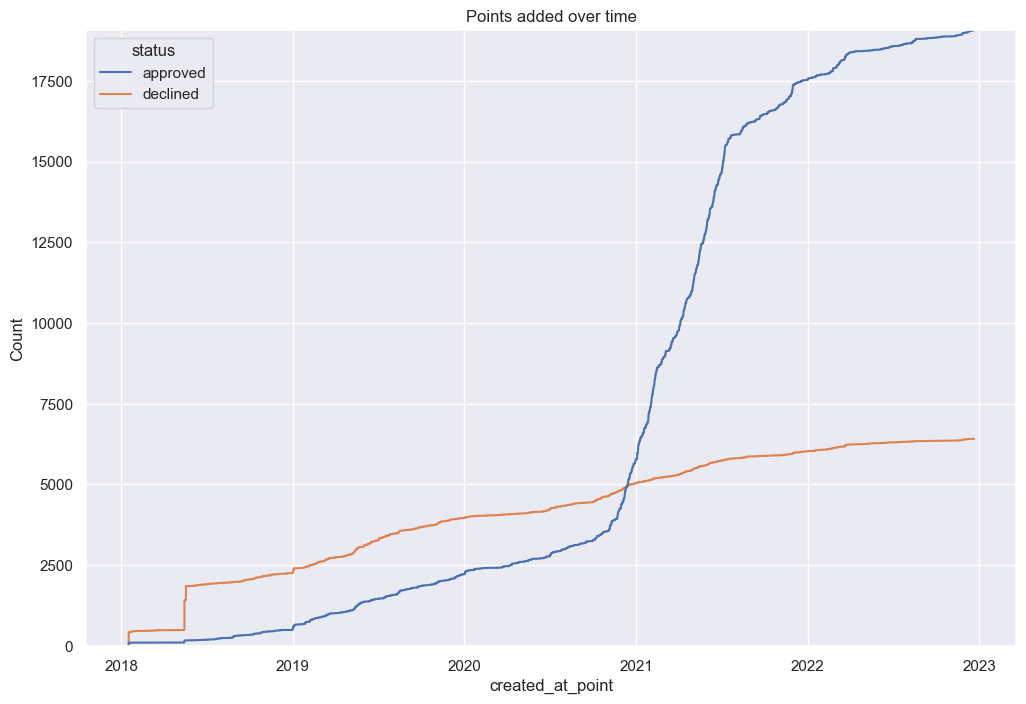

In [40]:
# How have the number of Points grown over time?
plt.figure(figsize=(12,8))
sns.ecdfplot(points, x='created_at_point', hue='status', stat='count')
plt.title('Points added over time')

In [41]:
# To have human readable Service names, join the tables (drop `id` so it's not confusing, since it refers to service id)
points = pd.merge(points, services, left_on='service_id', right_index=True, suffixes=['_point', '_service'])
points = points.drop('id', axis=1)

In [59]:
# For what Services do we have the most Points? What's the distribution of Points-per-Service?
point_counts = points[points.status == 'approved'].service_id.value_counts()
services.loc[point_counts.index, 'approved_points'] = point_counts.values
print(services.approved_points.describe())
services.sort_values('approved_points', ascending=False).head(15)[['name', 'approved_points']]

count    1528.000000
mean       12.482330
std        14.253242
min         1.000000
25%         2.000000
50%         7.000000
75%        18.000000
max        89.000000
Name: approved_points, dtype: float64


,name,approved_points
id,,
2428,Prezi,89.0
2453,iFunny,80.0
1815,Khan Academy,79.0
1553,Speedtest by Ookla,78.0
219,Instagram,77.0
1364,Brilliant,73.0
217,Google,72.0
2454,The Walt Disney Company,69.0
297,GitHub & Global Privacy Control,69.0


(0.0, 80.0)

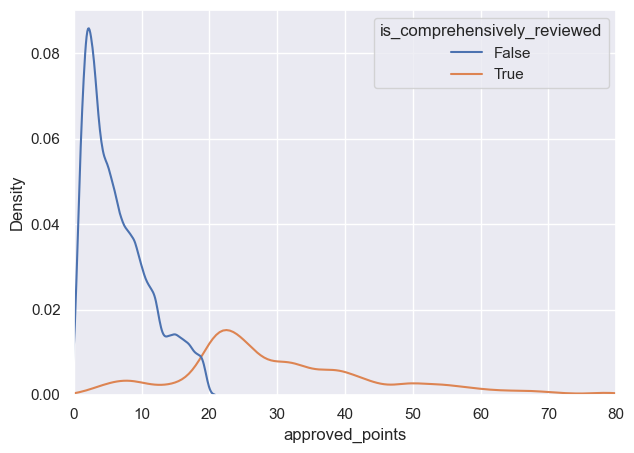

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.kdeplot(services[services.rating != 'N/A'], x='approved_points', hue='is_comprehensively_reviewed', ax=ax, bw_adjust=.5)
ax.set_xlim((0, 80))

In [45]:
# Looking at https://edit.tosdr.org/services/502 (the `(NONE)` service) it appears to be a mix of 
# discussions from a google group, spam, and random deleted Points that I can't place
# Researching that ^ also revealed a `none` Case: https://edit.tosdr.org/cases/235
# It seems to be used when disqualifying Points, and/or linked to random discussions from the google group
# Before removing, inspect. Are any of them approved?
print(cases.loc[235])
points[(points.case_id == 235) & (points.status == 'approved')]

id                                                               235
classification                                               neutral
score                                                              0
title                                                           none
description        Do not select this case, because points with t...
topic_id                                                          53
created_at                                2018-07-11 09:35:12.069597
updated_at                                2019-04-01 07:00:21.112429
privacy_related                                                 None
docbot_regex                                                    None
Name: 235, dtype: object


,id_point,user_id_point,title_point,source,status,analysis,created_at_point,updated_at_point,service_id,quoteText,...,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id_service,rating
id,,,,,,,,,,,,,,,,,,,,,
1126,1126,7,Instagram may sell your personal information a...,https://help.instagram.com/581066165581870,approved,"Per Instagram's terms: ""If we sell or otherwis...",2018-01-16 21:42:29.693236,2020-12-07 06:46:02.437691,219,<li>Our rights and obligations can be assigned...,...,"instagram.com,help.instagram.com,about.instagr...",2018-01-16 15:26:06.211757,2021-03-25 03:19:31.833924,https://en.wikipedia.org/wiki/Instagram,,,instagram,True,NaN,E


In [46]:
# There also appears to be a `none` Topic, which we can get rid of too

services = services.drop(502)
cases = cases.drop(235)
topics = topics.drop(53)
documents = documents.drop(1378)   # example doc
points = points[(points.service_id != 502) & (points.case_id != 235)]

In [47]:
# What are the distribution of Point counts per Case? What Cases have the most and least approved Points?
print(f"Points per Case stats:\n{points.case_id.value_counts().describe()}\n")
print(points.groupby(['case_id', 'title_case']).size().sort_values(ascending=False).head(15))
points.groupby(['case_id', 'title_case']).size().sort_values(ascending=False).tail(10)

Points per Case stats:
count     245.000000
mean       97.869388
std       111.735523
min         1.000000
25%        29.000000
50%        63.000000
75%       128.000000
max      1051.000000
Name: case_id, dtype: float64

case_id  title_case                                                                                                         
331      There is a date of the last update of the agreements                                                                   1051
152      This service is only available to users over a certain age                                                              513
286      The service is provided 'as is' and to be used at your sole risk                                                        480
163      The court of law governing the terms is in location X                                                                   394
323      You are tracked via web beacons, tracking pixels, browser fingerprinting, and/or device fingerprinting          

case_id  title_case                                                            
317      You aren’t allowed to publicly post private messages                      5
194      The service does not index or open files that you upload                  5
378      Service fines users for Terms of Service violations                       4
491      All Traffic is unencrypted (no https)                                     2
212      Pseudonyms are allowed due to the service's billing policies              2
494      An audio version of the Terms of Service is provided                      2
496      You can’t close your account if an investigation is ongoing               2
330      The service disables software that you are not licensed to use.           1
495      This service is only available for commercial use                         1
309      You have the right to request lower Charges from Third Party Providers    1
dtype: int64

In [48]:
# Way above there were some docs without text. Do these have points or can they be dropped?
textless_doc_ids = documents[documents.text.isna()].index
print(f"{len(textless_doc_ids)} docs with missing text")
textless_points = points[points.document_id.isin(textless_doc_ids)]
textless_points

2434 docs with missing text


,id_point,user_id_point,title_point,source,status,analysis,created_at_point,updated_at_point,service_id,quoteText,...,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id_service,rating
id,,,,,,,,,,,,,,,,,,,,,
6486,6486,1764,You maintain ownership of your data,https://contracts.pixelcatproductions.net/view...,declined,Generated through the annotate view,2019-05-11 21:23:53.858042,2021-02-06 04:16:15.925339,1529,Any content you upload is yours and must be yo...,...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6649,6649,1,You waive your right to a class action.,https://forums.pixelcatproductions.net/tos,declined,Generated through the annotate view,2019-05-16 04:45:19.947387,2021-02-06 04:16:27.787786,1529,"You will settle any dispute as an individual, ...",...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6391,6391,1764,Your personal data is given to third parties,https://contracts.pixelcatproductions.net/view...,declined,Generated through the annotate view,2019-05-05 21:37:33.260760,2021-02-06 04:02:09.255928,1529,We may employ third party companies and indivi...,...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6648,6648,1,The service can delete specific content withou...,https://forums.pixelcatproductions.net/tos,declined,Generated through the annotate view,2019-05-16 04:44:31.505792,2021-02-06 04:16:15.484760,1529,"The company reserves the right to change, reda...",...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6491,6491,1764,This service does not track you,https://contracts.pixelcatproductions.net/view...,declined,Generated through the annotate view,2019-05-11 21:32:16.288074,2019-08-01 04:05:15.512556,1529,We don't use any third party tracking software...,...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8431,8431,5121,Your personal data is used for limited purposes,https://chatpiserver.mynetgear.com/Privacy.html,declined,Generated through the annotate view,2019-11-21 22:33:24.912840,2021-02-06 04:16:26.110452,2014,This Usage Data may include information such a...,...,"chatpiserver.mynetgear.com,chatpiserver.tk",2019-11-21 22:17:52.248426,2021-03-25 03:19:41.921194,,None,None,chatpiserver,False,5121.0,N/A
8430,8430,5121,This service tracks which web page referred yo...,https://chatpiserver.mynetgear.com/Privacy.html,declined,Generated through the annotate view,2019-11-21 22:31:14.126486,2021-02-06 04:16:26.128977,2014,We use your data to provide and improve the Se...,...,"chatpiserver.mynetgear.com,chatpiserver.tk",2019-11-21 22:17:52.248426,2021-03-25 03:19:41.921194,,None,None,chatpiserver,False,5121.0,N/A
7218,7218,2231,Users are entitled to a refund if certain thre...,https://sunnahosstore-id.com/pages/mailing-and...,declined,Generated through the annotate view,2019-07-02 12:25:59.784839,2021-02-06 04:16:22.908195,1520,All orders are well packed and secured from ca...,...,sunnahosstore-id.com,2019-05-02 15:48:15.063221,2021-04-04 16:15:31.975604,,None,None,sunnah_onestop_store_idbooth_sg,False,NaN,N/A


In [49]:
# What services are these from?
textless_points.name.value_counts()

TunnelBear                                                       43
Pixelcat Productions JBAuth                                      30
Associação de Defesa da Privacidade Digital                      23
Uiiverse                                                         21
TopTree.cc (discontinued?)                                       16
vudu                                                             15
Medtinker                                                        15
Sophos                                                           13
Mailinator                                                       13
nickwasused.com                                                  11
Newegg.com                                                        9
Jagex (including RuneScape)                                       9
Bitcasa (discontinued?)                                           5
EBSCO                                                             5
Travelzoo                                       

In [50]:
# Drop text-less points and docs
points = points.drop(textless_points.index)
documents = documents.drop(textless_doc_ids)

In [51]:
# There are quite a few Points not associated with a doc
print(f"Docless Points: {len(points[points.document_id.isna()])}")
docless_approved = points[(points.status == 'approved') & (points.document_id.isna())]
print(f"Approved docless Points: {len(docless_approved)}")
print(f"Approved docless Points grouped by Case:")
print(docless_approved.groupby(['case_id', 'title_case']).size().sort_values(ascending=False).head(10))
docless_approved.head()
# These probably won't be useful, but for now we'll keep them in the dataset. There may be a way to associate them 
# with docs later and train doc->case classifiers (e.g. "easy to read")
# We can always drop later when forming per-case datasets.

Docless Points: 1630
Approved docless Points: 935
Approved docless Points grouped by Case:
case_id  title_case                                                                                            
199      The terms for this service are easy to read                                                               41
331      There is a date of the last update of the agreements                                                      27
163      The court of law governing the terms is in location X                                                     16
195      You can request access, correction and/or deletion of your data                                           16
193      Your personal data is not sold                                                                            15
128      Third-party cookies are used for advertising                                                              14
323      You are tracked via web beacons, tracking pixels, browser fingerprinting, and/or

,id_point,user_id_point,title_point,source,status,analysis,created_at_point,updated_at_point,service_id,quoteText,...,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id_service,rating
id,,,,,,,,,,,,,,,,,,,,,
4280,4280,435,easy to read,https://about.qwant.com/legal/privacy/,approved,easy to read,2018-06-09 07:47:42.197731,2018-06-26 08:51:35.009982,527,,...,"qwant.com,qwantjunior.com",2018-06-09 07:31:51.624829,2021-03-25 03:19:36.108592,https://en.wikipedia.org/wiki/Qwant,None,None,qwant,True,NaN,B
4931,4931,1004,The terms for this service are easy to read,https://todoist.com/privacy,approved,,2018-11-01 22:56:15.568223,2020-11-18 16:22:42.336584,809,None,...,todoist.com,2018-11-01 22:41:52.795155,2021-03-25 03:19:38.734350,https://en.wikipedia.org/wiki/Draft:Todoist,None,None,todoist,False,NaN,C
11157,11157,20783,The service provides a complete list of all co...,https://about.deviantart.com/policy/privacy/,approved,"The Privacy Policy states, ""Please check out t...",2020-11-08 22:09:26.198844,2020-11-28 17:09:31.557934,192,None,...,deviantart.com,2018-01-16 15:26:05.686813,2021-05-14 14:37:59.267933,https://en.wikipedia.org/wiki/DeviantArt,,,deviantart,True,NaN,B
6074,6074,395,This service does not force users into binding...,https://observablehq.com/terms-of-service,approved,,2019-03-13 14:01:20.652022,2019-06-23 00:36:08.424787,1447,None,...,observablehq.com,2019-03-13 13:18:15.484146,2021-03-25 03:19:43.912348,,None,None,observable,True,NaN,D
6411,6411,1,You cannot delete your account of this service,https://www.airbnb.com/help/article/240/how-do...,approved,You can not delete your account. You can only ...,2019-05-08 17:34:09.341048,2019-05-12 12:41:27.571265,168,None,...,"airbnb.com,abnb.me",2018-01-16 15:26:05.199014,2022-10-26 02:11:58.967922,https://en.wikipedia.org/wiki/Airbnb,,,airbnb,False,NaN,D


/var/folders/l5/210k0yvw8xj04j001s6yhlr00000gq/T/ipykernel_57308/3733395087.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(points.quote_len[points.quote_len < 1000], ax=ax, kde=False, norm_hist=False)


Text(0.5, 1.0, 'Quote lengths (num characters)')

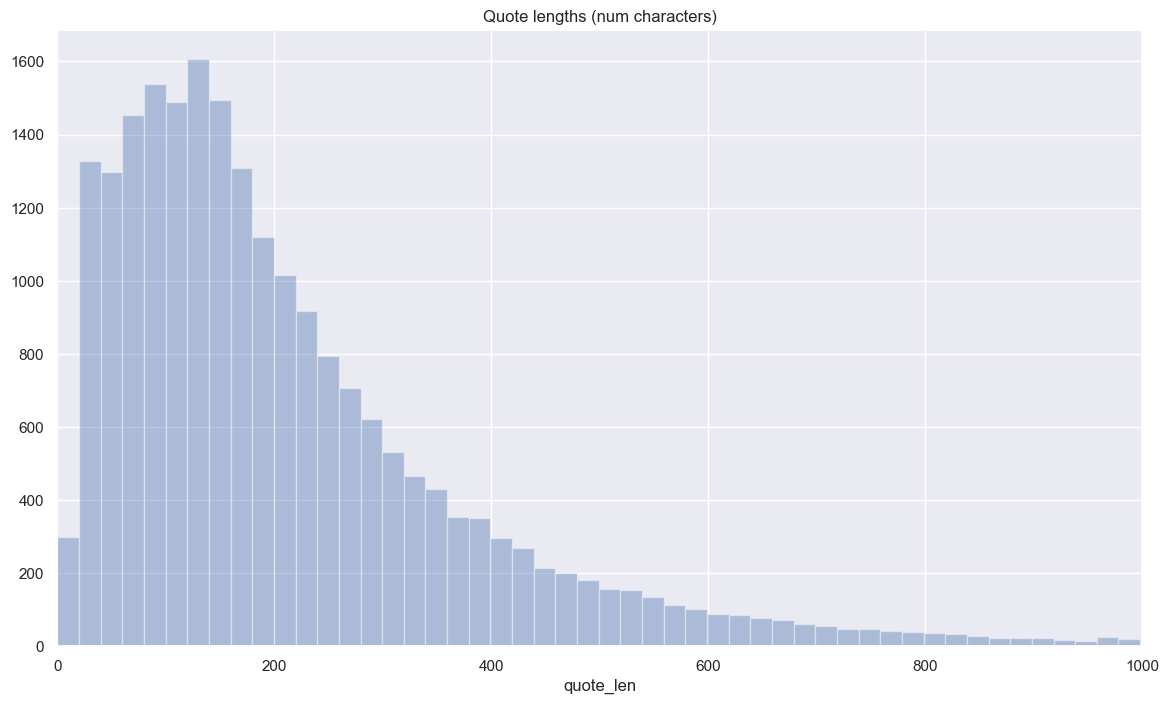

In [52]:
# What is the distribution of quote lengths?
points['quote_len'] = points.quoteEnd - points.quoteStart
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim((0,1000))
sns.distplot(points.quote_len[points.quote_len < 1000], ax=ax, kde=False, norm_hist=False)
plt.title('Quote lengths (num characters)')

In [53]:
# Examine outliers of shortest and largest quotes

# The shortest are probably just a single word or char highlighted out of the relevent sentence.
# We can come back to these when forming per-Case datasets
points.loc[points[points.status == 'approved'].quote_len.sort_values().head(30).index][['quoteText', 'title_case']]

,quoteText,title_case
id,,
21308,None,You can retrieve an archive of your data
21309,None,"You can request access, correction and/or dele..."
21310,None,Some personal data may be kept for business in...
7377,b,There is a date of the last update of the agre...
5583,,The terms for this service are easy to read
12707,IP,"This service may collect, use, and share locat..."
6533,may,There is a date of the last update of the agre...
4925,hate,"You agree not to submit libelous, harassing or..."
14795,Spam,"You are prohibited from sending chain letters,..."


In [54]:
# I think most of the longer ones are legitimate, highlighting whole paragraphs around a Case
# I'll probably shorten these by hand when forming per-Case datasets
points.loc[points[points.status == 'approved'].quote_len.sort_values(ascending=False).head(30).index][['quote_len', 'quoteText', 'title_case']]

,quote_len,quoteText,title_case
id,,,
19676,13166.0,"PDATE July 15, 2020:</strong> We have updated ...",The service claims to be CCPA compliant for Ca...
10777,8666.0,Annex 1 <p>\n<b>Purpose of processing</b>\n</p...,Details are provided about what kind of inform...
19758,8609.0,"<p>The following section on CCPA, Cal.\nCiv.\n...",The service claims to be CCPA compliant for Ca...
19757,8569.0,The following sections on GDPR applies to indi...,The service claims to be GDPR compliant for Eu...
20091,7387.0,California Consumer Privacy Act (CCPA) Notice ...,The service claims to be CCPA compliant for Ca...
751,3195.0,Sharing with Third-Party Partners We work with...,This service gives your personal data to third...
10273,3035.0,<strong>Click here</strong> to submit a copyri...,Instructions are provided on how to submit a c...
10108,3003.0,As Qualified asks others to respect its intell...,Instructions are provided on how to submit a c...
1374,2809.0,Here are the types of third parties we share i...,Many third parties are involved in operating t...


In [55]:
# Make sure empty string quoteText is nan
points.quoteText = points.quoteText.replace('', np.nan)

In [56]:
# Join Points with Documents, so we can check the quote contexts. Left join, because we are missing doc IDs for some
points = pd.merge(points, documents, how='left', left_on='document_id', right_index=True, suffixes=['_point', '_doc'])

In [57]:
# All Points associated with a doc have a quoteStart/quoteEnd, but some don't have a quoteText
print(points[(~points.document_id.isna())][['quoteText', 'quoteStart', 'quoteEnd']].info())
points[(~points.document_id.isna()) & points.quoteText.isna()][['title_point', 'status', 'quoteText', 'doc_len', 'quoteStart', 'quoteEnd']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22083 entries, 4513 to 28708
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   quoteText   22070 non-null  object 
 1   quoteStart  22083 non-null  float64
 2   quoteEnd    22083 non-null  float64
dtypes: float64(2), object(1)
memory usage: 690.1+ KB
None


,title_point,status,quoteText,doc_len,quoteStart,quoteEnd
id,,,,,,
11638,This service does not guarantee that it or the...,approved,None,1600.0,28384.0,28515.0
11630,The service provider makes no warranty regardi...,declined,None,1600.0,28519.0,28600.0
11628,"The service may use tracking pixels, web beaco...",declined,None,1600.0,28519.0,28600.0
8000,This service holds onto content that you've de...,declined,None,13329.0,6863.0,7050.0
8002,The service is provided 'as is' and to be used...,declined,None,13329.0,9326.0,9402.0
13277,The user is informed about security practices,declined,None,2658.0,10337.0,10497.0
14319,You waive your right to a class action.,declined,None,27113.0,78503.0,78673.0
14318,This service does not guarantee that it or the...,declined,None,27113.0,91276.0,91432.0
14321,This service forces users into binding arbitra...,declined,None,27113.0,77916.0,78356.0


In [58]:
# Most docless points don't have a quote at all
print(points[points.document_id.isna()][['quoteText', 'quoteStart', 'quoteEnd']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1630 entries, 15614 to 29465
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   quoteText   33 non-null     object 
 1   quoteStart  37 non-null     float64
 2   quoteEnd    37 non-null     float64
dtypes: float64(2), object(1)
memory usage: 50.9+ KB
None


In [59]:
# To be safe lets drop Points with quoteStart but no quoteText as anomolies
points = points.drop(points[(~points.quoteStart.isna()) & points.quoteText.isna()].index)
len(points)

23696

In [60]:
# Sanity check -- there should never be a case where a quote ends after the length of the Doc
# Uhoh, my guess is the Doc was updated after the fact
sum(points.doc_len < points.quoteEnd)

438

In [61]:
# Does quoteText match the document text from quoteStart to quoteEnd?
for i, point in points[~points.quoteStart.isna()].sample(10).iterrows():
    print(point.quoteText)
    print(point.text[int(point.quoteStart):int(point.quoteEnd)])
    print("=" * 30)

Blizzard’s failure to enforce a provision of this Agreement shall not be construed as a (1) waiver of such provision, or (2) diminishment of any right to enforce such provisions.
Blizzard’s failure to enforce a provision of this Agreement shall not be construed as a (1) waiver of such provision, or (2) diminishment of any right to enforce such provisions.
We have no obligation to post Member Content from you or anyone else and we may, in our sole discretion, edit, remove or delete any Member Content without notice.
We have no obligation to post Member Content from you or anyone else and we may, in our sole discretion, edit, remove or delete any Member Content without notice.
We have a policy of limiting access to our Services and terminating the accounts of users who infringe the intellectual property rights of others.
We have a policy of limiting access to our Services and terminating the accounts of users who infringe the intellectual property rights of others.
The Company reserves t

In [62]:
# Some of these match, others don't. Lets get a count.
points['quoteTextExtracted'] = points.apply(lambda point: point.text[int(point.quoteStart):int(point.quoteEnd)] if not (np.isnan(point.quoteStart) or pd.isnull(point.text)) else np.NaN, axis=1)
mismatching_quotes = points[(~points.quoteStart.isna()) & (points.quoteText != points.quoteTextExtracted)]
print(f"{len(mismatching_quotes)} extracted quotes don't match quoteText")
mismatching_quotes.sample(10)[['quoteText', 'quoteTextExtracted', 'id_doc', 'quoteStart', 'quoteEnd', 'service_id_point']]
# Yikes, that's a lot of mismatches. Since quoteTextExtracted doesn't respect sentence boundaries, this is surely because
# docs were updated but not aligned to reset quoteStart and quoteEnd.

3295 extracted quotes don't match quoteText


,quoteText,quoteTextExtracted,id_doc,quoteStart,quoteEnd,service_id_point
id,,,,,,
9979,"Therefore, we reserve the right to remove any ...",ty that is intended for all our users.\nTheref...,1380.0,14829.0,14965.0,1577
12612,Your choices about how we communicate with you...,\n<p>Your choices about how we communicate wit...,158.0,5493.0,5857.0,230
8115,We collect your name and contact information a...,"es, files, reminders, calendar, phone, messagi...",2028.0,1811.0,1950.0,1931
1019,The user is obliged </p> <p> (a) to provide on...,NaN,NaN,16291.0,16456.0,241
4760,"When you create or update your account, we col...",,619.0,1293.0,1490.0,743
10064,"IN ADDITION, THE COMPANY DOES NOT REPRESENT OR...",opyright infringement” in the subject of your ...,751.0,19537.0,19902.0,421
10280,"<p>8.3 In particular, we use the following thi...","out our services is displayed, a cookie will b...",1744.0,21725.0,22166.0,1638
5623,CARFAX web sites may contain web beacons to co...,to's uit meer\ndan 20 landen te verwerken.</p>...,977.0,3410.0,3832.0,1369
5999,In addition to the tracking technologies we pl...,we may enhance the content of our Services and...,1072.0,14921.0,15249.0,1443


In [63]:
# In order to form per-Case classification datasets and build effective models, we need to know the original context 
# for the quote. We could just discard these, but it would be nice to keep the datasets as large as possible.
# First, lets see if the out-of-date docs were kept and just marked `deleted`
documents_orig = pickle.load(open(f'../data/documents_{VERSION}.pkl', 'rb'))
documents_orig.loc[mismatching_quotes.id_doc.dropna()].status.value_counts()

Series([], Name: status, dtype: int64)

In [64]:
# That's a no. The next best option is to see if we can find the original quote text in the new doc.
# I wouldn't trust being able to place a quote that is found multiple times in the doc (especially given the 
# really short ones shown previously) but we can change quoteStart/quoteEnd if it's found once
points['quoteStartOrig'] = points.quoteStart.copy()
points['quoteEndOrig'] = points.quoteEnd.copy()
for i, point in mismatching_quotes.iterrows():
    if np.isnan(point.id_doc) or np.isnan(point.quoteStart):
        continue
    n_matches = point.text.count(point.quoteText)
    points.at[i,'n_quote_matches'] = n_matches
    if n_matches == 1:
        new_start = point.text.find(point.quoteText)
        points.at[i,'quoteStart'] = new_start
        points.at[i,'quoteEnd'] = new_start + len(point.quoteText)
print(points.loc[mismatching_quotes.index].n_quote_matches.describe())
print(f"{sum(points.quoteStart != points.quoteStartOrig)} updated or NaN")

count    3262.000000
mean        0.410791
std         1.730859
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        61.000000
Name: n_quote_matches, dtype: float64
2622 updated or NaN


In [65]:
# A little better, but still missing a ton
points['quoteTextExtracted'] = points.apply(lambda point: point.text[int(point.quoteStart):int(point.quoteEnd)] if not (np.isnan(point.quoteStart) or pd.isnull(point.text)) else np.NaN, axis=1)
mismatching_quotes = points[(~points.quoteStart.isna()) & (points.quoteText != points.quoteTextExtracted)]
print(f"{len(mismatching_quotes)} extracted quotes don't match quoteText")
print(mismatching_quotes.status.value_counts())

2266 extracted quotes don't match quoteText
declined    1943
approved     323
Name: status, dtype: int64


In [66]:
# That's as far as we'll go for now. We can always find a way to do whitespace-invarient comparison later.
# Remove the mismatched quotes. Given the `if n_matches == 1` above, this should filter out 0 or 2+ matches
points = points[(points.quoteText == points.quoteTextExtracted) | (points.quoteStart.isna())]
points = points.drop(['quoteTextExtracted', 'quoteStartOrig', 'quoteEndOrig'], axis=1)

In [67]:
# Points by language, since we didn't inspect it earlier
points.lang.value_counts()

en       18579
fr         586
es         163
zh-cn      160
de         137
nl          36
ru          30
th          25
pt          23
it          22
tr          20
ro          16
ko          12
cs           7
ja           5
et           5
hu           4
el           4
ca           2
da           1
Name: lang, dtype: int64

In [68]:
# One last sanity check: are there dangling foreign keys?
assert(len(set(documents.service_id) - set(services.index)) == 0)
assert(len(set(cases.topic_id) - set(topics.index)) == 0)
assert(len(set(points.service_id_point) - set(services.index)) == 0)
assert(len(set(points.case_id) - set(cases.index)) == 0)
assert(len(set(points.document_id.dropna()) - set(documents.index)) == 0)

In [69]:
# At this point, the datasets should be mostly clean (aside from some Points that don't reference Docs)
# There are some columns we need to drop/rename due to joins, and then we'll re-save
services.to_pickle(f'../data/services_{VERSION}_clean.pkl')

In [70]:
documents_orig = pickle.load(open(f'../data/documents_{VERSION}.pkl', 'rb'))
documents = documents[documents.columns[:13]]
documents = documents.rename({'id_doc': 'id', 'name_doc': 'name', 'url_doc': 'url', 'created_at_doc': 'created_at',
                                 'updated_at_doc': 'updated_at', 'user_id_doc': 'user_id'}, axis=1)
# Make sure columns names match original (but we're fine with dropped status, as we got rid of all `deleted` ones)
documents_orig = documents_orig.drop('status', axis=1)
documents.to_pickle(f'../data/documents_{VERSION}_clean.pkl')

In [71]:
topics.to_pickle(f'../data/topics_{VERSION}_clean.pkl')

In [72]:
cases.to_pickle(f'../data/cases_{VERSION}_clean.pkl')

In [73]:
points_orig = pickle.load(open(f'../data/points_{VERSION}.pkl', 'rb'))
points = points[points.columns[:16].tolist() + ['lang']]  # Keep lang because it's a little expensive to compute
points = points.rename({'id_point': 'id', 'user_id_point': 'user_id', 'title_point': 'title', 'created_at_point': 'created_at',
                                 'updated_at_point': 'updated_at', 'service_id_point': 'service_id'}, axis=1)
# Make sure columns names match original
points_orig = points_orig.drop(['oldId', 'rank'], axis=1)
points.to_pickle(f'../data/points_{VERSION}_clean.pkl')